In [1]:
using
    QuantumStates,
    OpticalBlochEquations,
    DifferentialEquations,
    UnitsToValue,
    LinearAlgebra,
    Printf,
    Plots,

    Random,
    StatsBase
;

using Distributions, Interpolations

import MutableNamedTuples: MutableNamedTuple
import StructArrays: StructArray, StructVector
import StaticArrays: @SVector, SVector
import LinearAlgebra: norm, ⋅, adjoint!, diag
import LoopVectorization: @turbo
using BenchmarkTools
using Parameters
using LsqFit

import ProgressMeter: Progress, next!

const λ = 626e-9
const Γ = 2π* 6.4e6
const m = @with_unit 57 "u"
const k = 2π / λ
_μB = (μ_B / h) * 1e-4;

include("CaOH_scan_helper_ODT_sequence_new.jl")
working_dir = "G:\\My Drive\\github\\OpticalBlochEquations\\examples\\ipynb_sources\\toy_models\\CaOH_scan"
# working_dir = "C:\\Users\\halla\\OneDrive\\Desktop\\blueMOT_sim\\repump"
;

In [2]:
package = get_CaOH_package();
package_A = get_CaOH_package_12_A_states();
n_states = length(package.states)
n_excited = package.n_excited;

In [3]:
function get_Δ_from_exp(voltage, aom_freq)
    # return Δ1, Δ2 in MHz
    Δ1 = 57 - 7.4*(5.5-voltage)
    Δ2 = Δ1 + 51.24 - aom_freq
    return Δ1, Δ2
end

get_Δ_from_exp (generic function with 1 method)

In [4]:
function get_ODT_Hamiltonian_matrix(package, package_A, peak_intensity, pol, wavelength=1064e-9)
    Is = π*h*c*Γ/(3λ^3) / 10 # saturation intensity in mW/cm^2
    s = peak_intensity / Is
    f_ODT = c/wavelength 
    
    n_states = length(package.states)
    E0 = sqrt(s)/(2 * √2) # factor?
    H_ODT = zeros(ComplexF64, n_states, n_states)
    
    d = package_A.d
    fs = energy.(package_A.states)

    
    for q in 1:3
        for p in 1:3
            
            for i in 1:n_states
                for j in 1:n_states
                    for l in 1:length(package_A.states)
                    H_ODT[i,j] -= 2π * Γ * (E0^2/4 * d[min(i,l),max(i,l),q] * pol[q] * d[min(j,l),max(j,l),p] * pol[p]) * 
                                    (1/(fs[l]-fs[i] - f_ODT) + 1/(fs[l]-fs[i] + f_ODT))
                    end
                end
            end
            
        end
    end
    
    return H_ODT
end

function particles_in_ODT(results)
    indicies = []
    number = 0.0
   for i in 1:length(results.x_trajectories)
        if abs(results.x_trajectories[i][end]) < 0.05 && abs(results.z_trajectories[i][end]) < 0.05 
            push!(indicies, i)
            number += exp(-results.photons_scattered[i]/14000)
        end 
    end
    return number, indicies
end

function generate_sequence!(sequence, timing)
    t_last = 0.0
    i_last = 1
   for params in sequence
        params.t_start = t_last
        params.t_end = t_last + timing[i_last]
        t_last = t_last + timing[i_last]
        i_last += 1
    end
end


# function get_ODT_Hamiltonian_matrix(package, peak_intensity, pol, wavelength=1064e-9)
#     H_ODT = zeros(ComplexF64, n_states, n_states)
#     for i in 1:16
#         H_ODT[i,i] = -1.0
#     end
#     return H_ODT
# end

generate_sequence! (generic function with 1 method)

In [85]:
temp = @with_unit 1.00 "mK"
diameter = @with_unit 0.6 "mm"
displacement = [0.0, 0.0, 0.0]*1e-3
kick = [0,0, 0.0, 0.0]
    



s1 = 1.5; s2 = 0.0; s3 = 1.; s4 = 1.5; Δ1 = 1.8Γ; Δ2 = 0.0; Δ3 = 1.4Γ; Δ4 = Δ3 + 1.75e6*2π; B_gradient = 75; ramp_time = 4e-3


# Δ_scan = LinRange(-0.4,0.4,20);
Δ_scan = LinRange(-0.4,0.4,10);
n_particles = 2000;

In [86]:
results_list = []

for Δ in Δ_scan
    @printf("Δ = %.2f Γ", Δ)
    blue_MOT_params = MutableNamedTuple(t_start = 0.0, t_end = 5e-3, n_values = n_particles,
                                pol1_x=σ⁻, pol2_x=σ⁻, pol3_x=σ⁺, pol4_x=σ⁻, 
                                s1=s1, s2=s2, s3=s3, s4=s4,
                                Δ1=Δ1, Δ2=Δ2, Δ3=Δ3+Δ*Γ, Δ4=Δ4+Δ*Γ, 
                                B_gradient = B_gradient, 
                                B_ramp_time = ramp_time,
                                Bz_offset = 0.0, By_offset = 0.0, Bx_offset=0.0,

                                temp=temp, diameter=diameter, 
                                displacement=displacement, kick=kick,
                                s_ramp_time = ramp_time,
                                s_ramp_to_factor = 1.0,

                                photon_budget=Inf, dark_lifetime=1/(1e6), FC_mainline=0.95,
                                pol_imbalance=0.00, 
                                s_imbalance = (0.0, 0.0, -0.00), retro_loss=0.00, 

                                off_center=[0, -0, -0, 0, 0, 0].*1e-3, 
                                pointing_error =[0.0, 0.0, 0,0,0,0],

                                ODT_intensity = 13.3*1e3/(50e-4)^2*0,
                                ODT_size = (30e-6, 2e-3, 30e-6), 
                                ODT_revolutions = 3,
                                ODT_rmax = 100e-6, # distance of radial motion
                                ODT_tmax = 30e-3, # timescale of radial motion
                                ODT_motion_t_start = 30e-3,
                                ODT_motion_t_stop = 50e-3)




    sequence = [blue_MOT_params]
    durations = [ramp_time + 1e-3]
    generate_sequence!(sequence, durations)

    test_i = log_test_info(working_dir,1,blue_MOT_params)
    @time results = simulate_particles_ODT(package, package_A, sequence, variable_budget=true);
    
    push!(results_list, results)

    @printf("goodness = %.2f",  goodness(blue_MOT_params.t_end, results))
    println()
end

Δ = -0.40 Γ

Progress: 100%|█████████████████████████████████████████| Time: 0:16:17


977.469053 seconds (3.22 M allocations: 662.788 MiB, 0.01% gc time)
Survival: 1081 / 2000
goodness = 0.08
Δ = -0.31 Γ

Progress: 100%|█████████████████████████████████████████| Time: 0:18:34


1114.827484 seconds (3.27 M allocations: 679.558 MiB, 0.01% gc time)
Survival: 1677 / 2000
goodness = 0.28
Δ = -0.22 Γ

Progress: 100%|█████████████████████████████████████████| Time: 0:18:51


1131.478086 seconds (3.27 M allocations: 683.295 MiB)
Survival: 1833 / 2000
goodness = 0.45
Δ = -0.13 Γ

Progress: 100%|█████████████████████████████████████████| Time: 0:18:42


1122.340379 seconds (3.29 M allocations: 685.978 MiB, 0.01% gc time)
Survival: 1922 / 2000
goodness = 0.57
Δ = -0.04 Γ

Progress: 100%|█████████████████████████████████████████| Time: 0:18:37                                                                                                                                                                  


1117.073527 seconds (3.28 M allocations: 684.858 MiB, 0.01% gc time)
Survival: 1893 / 2000
goodness = 0.58
Δ = 0.04 Γ

Progress: 100%|█████████████████████████████████████████| Time: 0:18:34


1114.433601 seconds (3.28 M allocations: 684.459 MiB, 0.01% gc time)
Survival: 1855 / 2000
goodness = 0.53
Δ = 0.13 Γ

Progress: 100%|█████████████████████████████████████████| Time: 0:18:12


1092.060887 seconds (3.27 M allocations: 679.588 MiB, 0.01% gc time)
Survival: 1677 / 2000
goodness = 0.33
Δ = 0.22 Γ

Progress: 100%|█████████████████████████████████████████| Time: 0:17:42Progress:  96%|████████████████████████████████████████ |  ETA: 0:00:40


1062.714205 seconds (3.24 M allocations: 672.070 MiB, 0.01% gc time)
Survival: 1411 / 2000
goodness = 0.10
Δ = 0.31 Γ

Progress: 100%|█████████████████████████████████████████| Time: 0:17:05


1025.425752 seconds (3.23 M allocations: 665.102 MiB)
Survival: 1126 / 2000
goodness = 0.03
Δ = 0.40 Γ

Progress: 100%|█████████████████████████████████████████| Time: 0:15:54


954.751238 seconds (3.21 M allocations: 657.006 MiB, 0.01% gc time)
Survival: 814 / 2000
goodness = 0.01


In [87]:
serialize("C:\\Users\\halla\\OneDrive\\Desktop\\blueMOT_sim\\parameter_scans\\scan_d34_2000.jl", results_list)

In [7]:
# results_list = deserialize("C:\\Users\\halla\\OneDrive\\Desktop\\blueMOT_sim\\parameter_scans\\scan_d34_100.jl");

In [23]:
Δ_scan

20-element LinRange{Float64, Int64}:
 -0.4, -0.357895, -0.315789, -0.273684, …, 0.273684, 0.315789, 0.357895, 0.4

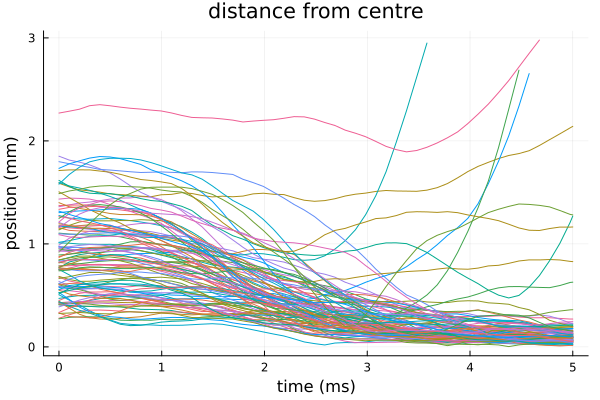

In [74]:
plot_all_trajectories(results_list[7],"all")
plot!()

In [6]:
function bootstrap_iteration(results; n_values=nothing)
    if n_values == nothing
        n_values = length(results.times)
    end
    indicies = rand(1:length(results.times),n_values)
    results1 = deepcopy(results)
    results1.x_trajectories = Array{Vector{Float64}}(fill([],n_values))
    results1.y_trajectories = Array{Vector{Float64}}(fill([],n_values)) 
    results1.z_trajectories = Array{Vector{Float64}}(fill([],n_values))
    results1.x_velocities = Array{Vector{Float64}}(fill([],n_values))
    results1.y_velocities = Array{Vector{Float64}}(fill([],n_values))
    results1.z_velocities = Array{Vector{Float64}}(fill([],n_values))
    results1.times = Array{Vector{Float64}}(fill([],n_values))
    results1.photons_scattered = zeros(n_values)
    
    for i in 1:n_values
        i_bs = indicies[i]
        results1.x_trajectories[i] = results.x_trajectories[i_bs]
        results1.y_trajectories[i] = results.y_trajectories[i_bs]
        results1.z_trajectories[i] = results.z_trajectories[i_bs]
        results1.x_velocities[i] = results.x_velocities[i_bs]
        results1.y_velocities[i] = results.y_velocities[i_bs]
        results1.z_velocities[i] = results.z_velocities[i_bs]
        results1.times[i] = results.times[i_bs]
        results1.photons_scattered[i] = results.photons_scattered[i_bs]
    end
    return results1
end

function gaussian(x, p)
   A, σ, x0 = p[1], p[2], p[3]
    return A * exp.(-(x .- x0).^2 / (2*σ^2))
end

function bootstrap_size(results; iter = 10, n_values=nothing)
    sizes = []
    for i in 1:iter
        results1 = bootstrap_iteration(results, n_values=n_values)
        _,sx, sy, sz = plot_size(results1, "all")
        push!(sizes, (sx[end]*sy[end]*sz[end])^(1/3))
    end
        
    return mean(sizes), std(sizes)
end
    
function bootstrap_size_fit(results; iter = 10, n_values=nothing, t_end=5e-3)
    sizes = []
    x_grid = collect(LinRange(-0.5, 0.5, 20))
    for i in 1:iter
        results1 = bootstrap_iteration(results, n_values=n_values)
    
        id_survived = survived(t_end, results1.times)
    
        xs = [results1.x_trajectories[j][end] for j in id_survived]
        density_x = distribution_to_func(x_grid, xs)
        p0 = [10, 0.1, 0.0]
        fit_x = curve_fit(gaussian, x_grid, density_x, p0)
        sx = fit_x.param[2]
    
        ys = [results1.y_trajectories[j][end] for j in id_survived]
        density_y = distribution_to_func(x_grid, xs)
        p0 = [10, 0.1, 0.0]
        fit_y = curve_fit(gaussian, x_grid, density_y, p0)
        sy = fit_y.param[2]
    
        zs = [results1.z_trajectories[j][end] for j in id_survived]
        density_z = distribution_to_func(x_grid, zs)
        p0 = [10, 0.1, 0.0]
        fit_z = curve_fit(gaussian, x_grid, density_z, p0)
        sz = fit_z.param[2]

    
    
        push!(sizes, (sx[end]*sy[end]*sz[end])^(1/3))
    end
        
    return mean(sizes), std(sizes)
end

function distribution_to_func(x_grid, trajectories)
    func = x_grid .* 0.0
    dx = x_grid[2]-x_grid[1]
    for x in trajectories
       id_x = Int((x - x_grid[1]) ÷ dx)
        if 1<= id_x <= length(x_grid)
            func[id_x] += 1.0
        end
    end
    return func
end

    
function bootstrap_survival(results; iter=10, n_values = nothing)
    signals = []

    for i in 1:iter
        results1 = bootstrap_iteration(results, n_values=n_values)
        n = survival_signal(5e-3, results1, photon_budget=12000)
        push!(signals, n)
    end
        
    return mean(signals), std(signals)
end
    
function bootstrap_temperature(results; iter=10, n_values=nothing)
    temperatures = []

    for i in 1:iter
        results1 = bootstrap_iteration(results, n_values=n_values)
        Tx = plot_temperature(results1, "x")[end]
        Ty = plot_temperature(results1, "y")[end]
        Tz = plot_temperature(results1, "z")[end]
        push!(temperatures, (Tx[end]*Ty[end]*Tz[end])^(1/3))
    end
    
    return mean(temperatures), std(temperatures)
    
end
    
function bootstrap_temperature_fit(results; iter=10, n_values=nothing)
    temperatures = []
    x_grid = collect(LinRange(-0.5, 0.5, 20))
    for i in 1:iter
        results1 = bootstrap_iteration(results, n_values=n_values)
    
        id_survived = survived(t_end, results1.times)
    
        xs = [results1.x_velocities[j][end] for j in id_survived]
        density_x = distribution_to_func(x_grid, xs)
        p0 = [10, 0.1, 0.0]
        fit_x = curve_fit(gaussian, x_grid, density_x, p0)
        k_B = 1.38e-23
        sx = m * fit_x.param[2]^2 /k_B *1e6
    
        ys = [results1.y_velocities[j][end] for j in id_survived]
        density_y = distribution_to_func(x_grid, xs)
        p0 = [10, 0.1, 0.0]
        fit_y = curve_fit(gaussian, x_grid, density_y, p0)
        sy = m * fit_y.param[2]^2 /k_B *1e6
    
        zs = [results1.z_velocities[j][end] for j in id_survived]
        density_z = distribution_to_func(x_grid, zs)
        p0 = [10, 0.1, 0.0]
        fit_z = curve_fit(gaussian, x_grid, density_z, p0)
        sz = m * fit_z.param[2]^2 /k_B *1e6

       

    
        push!(temperatures, (sx[end]*sy[end]*sz[end])^(1/3))
    end
        
    return mean(temperatures), std(temperatures)
end
    

bootstrap_temperature_fit (generic function with 1 method)

In [100]:
rand()

0.2361017361590091

0.031820528802917754
0.4837922733567481


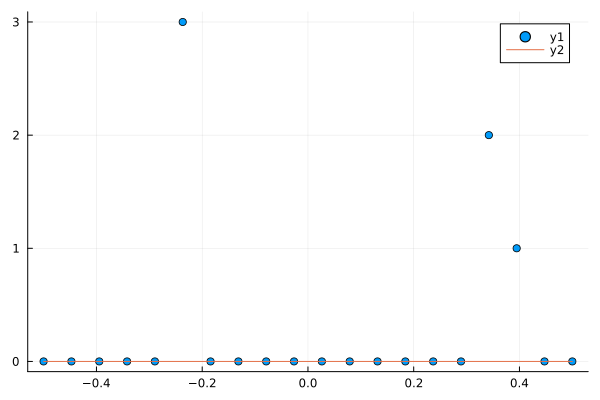

In [66]:
n_values = 100
results = results_list[end]
t_end = 5e-3

sizes = []
x_grid = collect(LinRange(-0.5, 0.5, 20))

    results1 = bootstrap_iteration(results, n_values=n_values)

    id_survived = survived(t_end, results1.times)

    xs = [results1.z_trajectories[j][end] for j in id_survived]
    density_x = distribution_to_func(x_grid, xs)


    p0 = [50, 0.05,0.0]
    fit = curve_fit(gaussian, x_grid, density_x, p0);
    k_B = 1.38e-23

    println(fit.param[2])
    println(plot_size(results1, "x")[2][end])
#     println(m * fit.param[2]^2 /k_B *1e6)

# println(plot_temperature(results1, "x")[2][end])
scatter(x_grid, density_x)
plot!(x_grid, gaussian(x_grid, fit.param))

In [88]:
sizes = []
errors = []
for results in results_list
    size, error = bootstrap_size(results; iter=100)
    push!(sizes, size)
    push!(errors, error)
end
    
plot(Δ_scan, sizes,color="green", xlabel="Detuning change (Γ)", ylabel="Size (mm)",label=@sprintf("Std (%i particles)", n_particles),
ribbon=(errors, errors),fc=:green,fa=0.3);

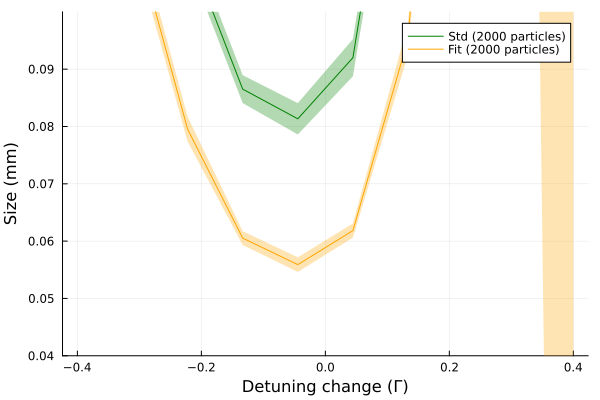

In [89]:
sizes = []
errors = []
for results in results_list
    size, error = bootstrap_size_fit(results; iter=100)
    push!(sizes, size)
    push!(errors, error)
end
    
plot!(Δ_scan, sizes,color="orange", xlabel="Detuning change (Γ)", ylabel="Size (mm)",label=@sprintf("Fit (%i particles)", n_particles),
ribbon=(errors, errors),fc=:orange,fa=0.3)

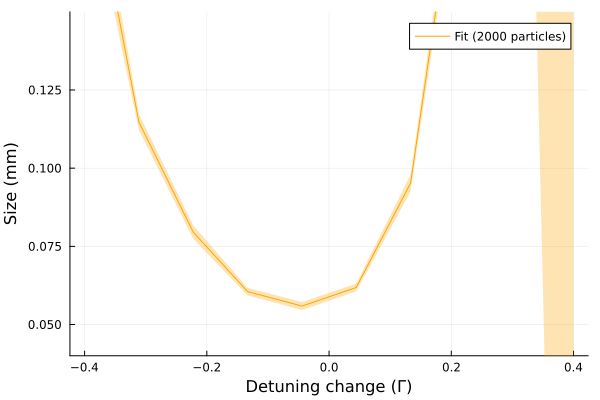

In [92]:
plot(Δ_scan, sizes,color="orange", xlabel="Detuning change (Γ)", ylabel="Size (mm)",label=@sprintf("Fit (%i particles)", n_particles),
ribbon=(errors, errors),fc=:orange,fa=0.3)
plot!(ylim=[0.04,0.15])

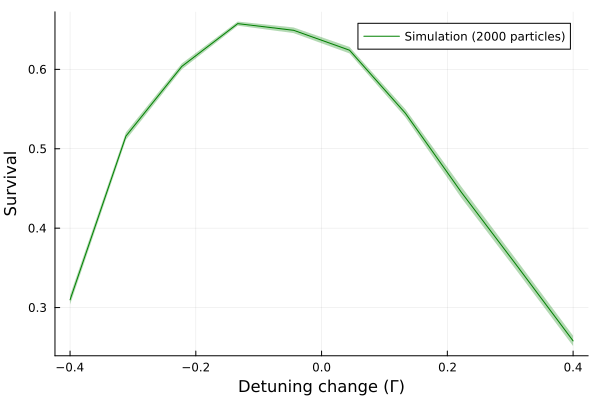

In [93]:
signals = []
errors = []

for results in results_list[1:end]
    signal, error = bootstrap_survival(results, iter=100)
    push!(signals, signal)
    push!(errors, error)
end
    
# scatter(s_mult_scan[1:end], signals, yerr=errors, xlabel="Intensity", ylabel="Survival")
plot(Δ_scan[1:end], signals,color="green", xlabel="Detuning change (Γ)", ylabel="Survival",label=label=@sprintf("Simulation (%i particles)", n_particles),
ribbon=(errors, errors),fc=:green,fa=0.3)

In [82]:
temperatures = []
errors = []

for results in results_list[2:17]
    temp, error = bootstrap_temperature(results, iter=100)
    push!(temperatures, temp)
    push!(errors, error)
end
    
plot(Δ_scan[2:17], temperatures,color="green", xlabel="Detuning change (Γ)", ylabel="Temperature (μK)",label=@sprintf("Std (%i particles)", n_particles),
ribbon=(errors, errors),fc=:green,fa=0.3);

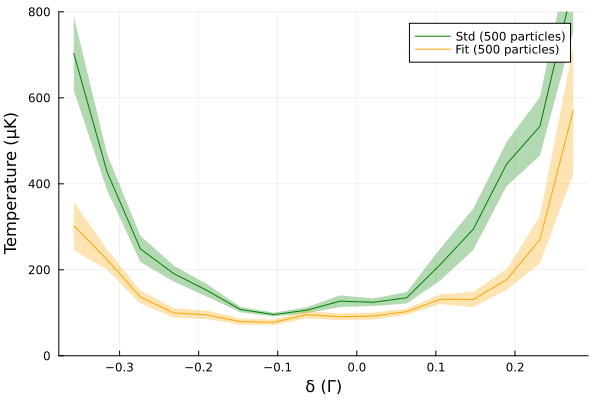

In [83]:
temperatures = []
errors = []

for results in results_list[2:17]
    temp, error = bootstrap_temperature_fit(results, iter=100)
    push!(temperatures, temp)
    push!(errors, error)
end
    
plot!(Δ_scan[2:17], temperatures,color="orange", xlabel="δ (Γ)", ylabel="Temperature (μK)",label=@sprintf("Fit (%i particles)", n_particles),
ribbon=(errors, errors),fc=:orange,fa=0.3)
plot!(ylim=(0,800))

In [57]:
using Optim

# Define the 2D Gaussian function
function gaussian2d(x, y, p)
    xc, yc, σx, σy, A = p
    return A * exp.(-((x .- xc) .^ 2 / (2 * σx^2) + (y .- yc) .^ 2 / (2 * σy^2)))
end


function least_sq_cost(params)
    predicted = [gaussian2d(xx, zz, params) for xx in x, zz in z]
    return sum((predicted - grids).^2)
end

using Optim
;

function get_trapped_indicies(param, results)
   t_max =  param.t_end*1e3
    trapped_indicies = Int[]
    for i in 1:length(results.times)
        if results.times[i][end] ≈ t_max
           push!(trapped_indicies, i) 
        end
    end
    return trapped_indicies
end;

function make_2D_image(results, x_min, x_max, n_pixels;t=0.0,photon_budget=Inf)
    """ grids = population """
    max_t_id = 1
     plot_ts = Float64[]
    for i in 1:length(results.times)
         if length(results.times[i]) > max_t_id
             max_t_id = length(results.times[i])  
             plot_ts = results.times[i]
         end                                                                                                          
     end
   dt = plot_ts[2] - plot_ts[1]
    it = Int(t ÷ dt) + 1

    grids = zeros(n_pixels, n_pixels)
    x = LinRange(x_min, x_max, n_pixels)
    dx = x[2]-x[1]
    z = LinRange(x_min, x_max, n_pixels)
    for i in 1:length(results.times)
        if it > length(results.times[i])
            continue
        end
        x_end = results.x_trajectories[i][it]
        z_end = results.z_trajectories[i][it]
        n_photons = sum(results.A_populations[i][1:it]*dt*Γ/1000)
       if  (x_min < x_end < x_max) && (x_min < z_end < x_max)
           ix = Int((x_end - x_min) ÷ dx + 1)
            iz = Int((z_end - x_min) ÷ dx + 1)
            grids[ix, iz] += 1 * exp(-n_photons / photon_budget)
        end
    end
    return x, z, grids
end

function take_camera_image(results, x_min, x_max, n_pixels;t=0.0, t_img=0.0, const_scattering=false, noise=0.0,photon_budget=Inf)
    x, z, grids = make_2D_image(results, x_min, x_max, n_pixels;t=t, photon_budget=photon_budget)
    dt = 0.5
    if const_scattering
        grids = grids .* dt 
    else
        grids = grids .* scattering_rate_at_t(results, t+0.1) * dt 
    end
    if t_img <= 0.5
        return x, z, grids
    else
        t_curr = t + dt
        while t_curr < t + t_img
            ~,~,grids1 = make_2D_image(results, x_min, x_max, n_pixels;t=t_curr, photon_budget=photon_budget)
            if const_scattering
                grids = grids .+ grids1 * dt
            else
                grids = grids .+ grids1 * scattering_rate_at_t(results, t_curr) * dt
            end
            t_curr += dt
        end
        grids = grids .+ (rand(length(x), length(z)).- 0.5).*t_img * noise
        return x, z, grids # grids = brightness
    end
end

function goodness(t_end, results)
    
    times, x_trajectories, y_trajectories, z_trajectories = results.times, results.x_trajectories, results.y_trajectories, results.z_trajectories
    
    # Sample number of photons before the molecule is lost to vibrational dark state
    n_molecules = length(times)
    
    _survived = survived(t_end,times)
    @printf("Survival: %i / %i", length(_survived), n_molecules)
    println()
    
    surviving_x_trajectories = x_trajectories[_survived]
    surviving_y_trajectories = y_trajectories[_survived]
    surviving_z_trajectories = z_trajectories[_survived]
    
    n = 0
    for survived_idx ∈ _survived
        idx_end = length(x_trajectories[survived_idx])
        r = distance(x_trajectories[survived_idx], y_trajectories[survived_idx], z_trajectories[survived_idx], idx_end)
        if r > 1.0
            n += 0.0
        elseif r > 0.5
            n += 0.1 * exp(-results.photons_scattered[survived_idx]/14000)
        elseif r > 0.3
            n += (0.6 - r)* exp(-results.photons_scattered[survived_idx]/14000)
        elseif r <= 0.3
            n += ((0.3 - r) * 3 + 0.3) * exp(-results.photons_scattered[survived_idx]/14000)
        end
    end
    return n/n_molecules
end
;
function survived(t_end, times)
    _survived = Int64[]
    for i ∈ eachindex(times)
        if abs(times[i][end] - t_end*1e3) <= 1.0
            push!(_survived, i)
        end
    end
    return _survived
end;
function cloud_size(trajectories, i)
    std(trajectory[i] for trajectory ∈ trajectories)
end

"""
    Evaluates the density given a set of trajectories.
"""
function density(t_end, results)
    
    times, x_trajectories, y_trajectories, z_trajectories = results.times, results.x_trajectories, results.y_trajectories, results.z_trajectories
    
    # Sample number of photons before the molecule is lost to vibrational dark state
    n_molecules = length(times)
    
    _survived = survived(t_end, times)
    println(_survived)
    
    surviving_x_trajectories = x_trajectories[_survived]
    surviving_y_trajectories = y_trajectories[_survived]
    surviving_z_trajectories = z_trajectories[_survived]
    
    n = length(_survived)
    _density = Float64(n)
    if n > 1
        idx_end = length(surviving_x_trajectories[1])
        σ_x = cloud_size(surviving_x_trajectories, idx_end)
        σ_y = cloud_size(surviving_y_trajectories, idx_end)
        σ_z = cloud_size(surviving_z_trajectories, idx_end)
        _density /= σ_x * σ_y * σ_z
    end
    return _density
end

function distance(x_trajectory, y_trajectory, z_trajectory, idx)
    return sqrt(x_trajectory[idx]^2 + y_trajectory[idx]^2 + z_trajectory[idx]^2)
end


function survival_signal(t_end, results; photon_budget = 14000)
    
    times, x_trajectories, y_trajectories, z_trajectories = results.times, results.x_trajectories, results.y_trajectories, results.z_trajectories
    
    # Sample number of photons before the molecule is lost to vibrational dark state
    n_molecules = length(times)
    
    _survived = survived(t_end, times)
#     @printf("Survival: %i / %i", length(_survived), n_molecules)
#     println()
    
    surviving_x_trajectories = x_trajectories[_survived]
    surviving_y_trajectories = y_trajectories[_survived]
    surviving_z_trajectories = z_trajectories[_survived]
    
    n = 0
    for survived_idx ∈ _survived
        idx_end = length(x_trajectories[survived_idx])
        n += exp(-results.photons_scattered[survived_idx]/photon_budget)
    end
    return n/n_molecules
end
;